## BoomBikes Bike Sharing Assignment

A bike-sharing system is a service in which bikes are made available for shared use to individuals on a short term basis for a price or free. Many bike share systems allow people to borrow a bike from a "dock" which is usually computer-controlled wherein the user enters the payment information, and the system unlocks it. This bike can then be returned to another dock belonging to the same system.

Understand the factors on which the demand for these shared bikes depends.
- Which variables are significant in predicting the demand for shared bikes.
- How well those variables describe the bike demands

##### Data understanding, preparation and EDA 

In [112]:
# importing required libraries
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

In [113]:
# loading dataset
df_bike = pd.read_csv('day.csv')
# print the info of dataframe
df_bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


- There are no missing values in the data set, hence no missing value treatment needed here.<br>
- 'dteday' is object, this need to be splited if this need to be used for modelling.<br>

In [114]:
df_bike.head(2)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801


- Data discription states 'casual' and 'registered' are count of rental bikes and it is included in 'cnt'. Hence the variables are not needed for model.<br>
- Variable 'instant' is not contribuing to model building hence will be removed from the data set.
- Variable 'dteday' is date information. Dropping thsi since the dataset has detailed logical extract of date as features.
- Variable 'atemp' is a transformation of feature 'temp' and 'hum'. Dropping 'temp' and 'hum' since this is redundant.

In [115]:
# dropping 'instant', 'dteday', 'temp', 'hum', 'casual' and 'registered'
df_bike.drop(columns=['instant', 'dteday', 'temp', 'hum', 'casual', 'registered'], inplace=True)

In [116]:
df_bike.head(2)

,season,yr,mnth,holiday,weekday,workingday,weathersit,atemp,windspeed,cnt
0,1,0,1,0,6,0,2,18.18125,10.749882,985
1,1,0,1,0,0,0,2,17.68695,16.652113,801


- The variables 'season' 'yr' 'mnth' 'holiday', 'weekday', 'workingday', and 'weathersit' are categorical 
- The variables 'atemp'  and 'windspeed' are continuous 

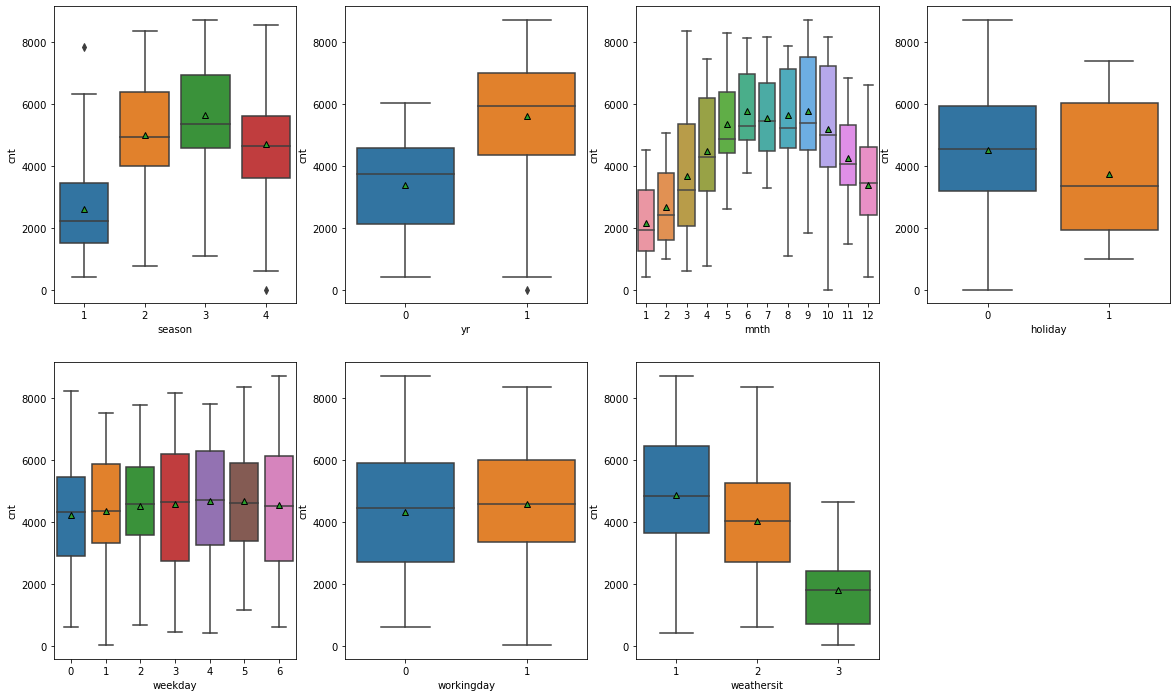

In [120]:
# visualising the categorical variables
plt.figure(figsize=(20, 12))
plt.subplot(2,4,1)
sns.boxplot(x='season', y='cnt', data=df_bike, showmeans=True, meanprops={"markeredgecolor": "black"})

plt.subplot(2,4,2)
sns.boxplot(x='yr', y='cnt', data=df_bike, showmeans=True, meanprops={"markeredgecolor": "black"})

plt.subplot(2,4,3)
sns.boxplot(x='mnth', y='cnt', data=df_bike, showmeans=True, meanprops={"markeredgecolor": "black"})

plt.subplot(2,4,4)
sns.boxplot(x='holiday', y='cnt', data=df_bike, showmeans=True, meanprops={"markeredgecolor": "black"})

plt.subplot(2,4,5)
sns.boxplot(x='weekday', y='cnt', data=df_bike, showmeans=True, meanprops={"markeredgecolor": "black"})

plt.subplot(2,4,6)
sns.boxplot(x='workingday', y='cnt', data=df_bike, showmeans=True, meanprops={"markeredgecolor": "black"})

plt.subplot(2,4,7)
sns.boxplot(x='weathersit', y='cnt', data=df_bike, showmeans=True, meanprops={"markeredgecolor": "black"})
plt.show()

- Data shows below inferences on the categorical values against the total rentals
    - There is a significant difference in the rentals on different season.
    - Higher rentals year over year.
    - Higher rentals on non-holidays.
    - No rentals and weather situation category 4. There is a gradual decrease in rentals based on the bad weather.
    - Rentals are similar irrespective of working day or non-working day.
    - Months can be represented by the season.

In [78]:
# The feature 'season' is collection of 'mnth'. Season is more aligned with the dependent variable.
# Since season is better indicator for the model, dropping mnth here.
df_bike.drop(columns=['mnth'], inplace=True)

In [79]:
# Since there seems not difference in usage, making the model simple by dropping it.
df_bike.drop(columns=['weekday'], inplace=True)

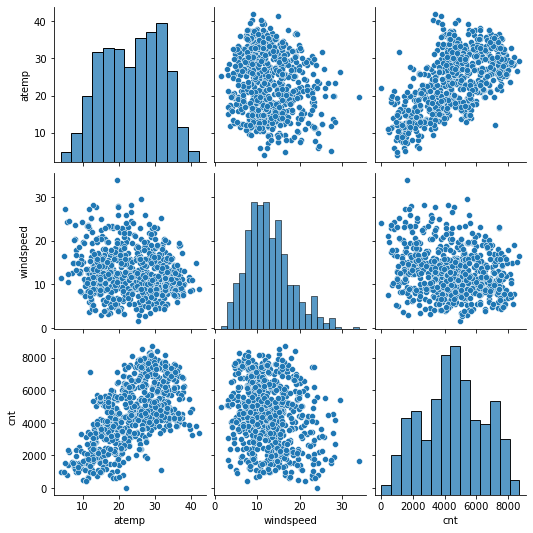

In [80]:
# plotting the continuous variables.
sns.pairplot(df_bike[['atemp', 'windspeed', 'cnt']])

- There is linear relation between atemp and rental

In [81]:
# categorical variable 'season' to dummy values
seasons = df_bike['season'].map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})
seasons = pd.get_dummies(seasons, drop_first=True)

# renaming yr to more intutive name
df_bike.rename(columns = {'yr':'yr_2019'}, inplace = True)

# categorical variable 'mnth' to dummy vars
#months = df_bike['mnth'].map({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'})
#months = pd.get_dummies(months, drop_first=True)

# categorical variable 'weekday' to dummy variable
#days = pd.get_dummies(df_bike['weekday'], prefix='Day', prefix_sep='_', drop_first=True)

# categorical variable 'weathersit' to dummy variable
weather = df_bike['weathersit'].map({1:'weather_normal', 2:'weather_mist', 3:'weather_lilght', 4:'weather_heavy'})
weather = pd.get_dummies(weather, drop_first=True)

#df_bike.drop(columns=['season', 'mnth', 'weekday', 'weathersit'], inplace=True)
#df_bike = pd.concat([df_bike, seasons, months, days, weather], axis=1)
df_bike.drop(columns=['season', 'weathersit'], inplace=True)
df_bike = pd.concat([df_bike, seasons, weather], axis=1)

#### Model building and evaluation 

- Split the data set into train and test

In [83]:
# split to train and test
df_train, df_test = train_test_split(df_bike, train_size=0.7, random_state=100)
print(df_train.shape)
print(df_test.shape)

(510, 11)
(220, 11)


- rescale

In [85]:
# normalize the values
scalar = MinMaxScaler()
# create a list of numeric vars
num_vars = ['atemp', 'windspeed', 'cnt']

#2. Fit and transform
    
df_train[num_vars] = scalar.fit_transform(df_train[num_vars])
df_test[num_vars] = scalar.transform(df_test[num_vars])
#df_train.head()

In [86]:
df_train[num_vars].describe()

,atemp,windspeed,cnt
count,510.000000,510.000000,510.000000
mean,0.513156,0.320883,0.513499
std,0.212410,0.169803,0.224421
min,0.000000,0.000000,0.000000
25%,0.332086,0.199179,0.356420
50%,0.529718,0.296763,0.518638
75%,0.688457,0.414447,0.684710
max,1.000000,1.000000,1.000000


- training model

In [87]:
df_train.columns

Index(['yr_2019', 'holiday', 'workingday', 'atemp', 'windspeed', 'cnt',
       'spring', 'summer', 'winter', 'weather_mist', 'weather_normal'],
      dtype='object')

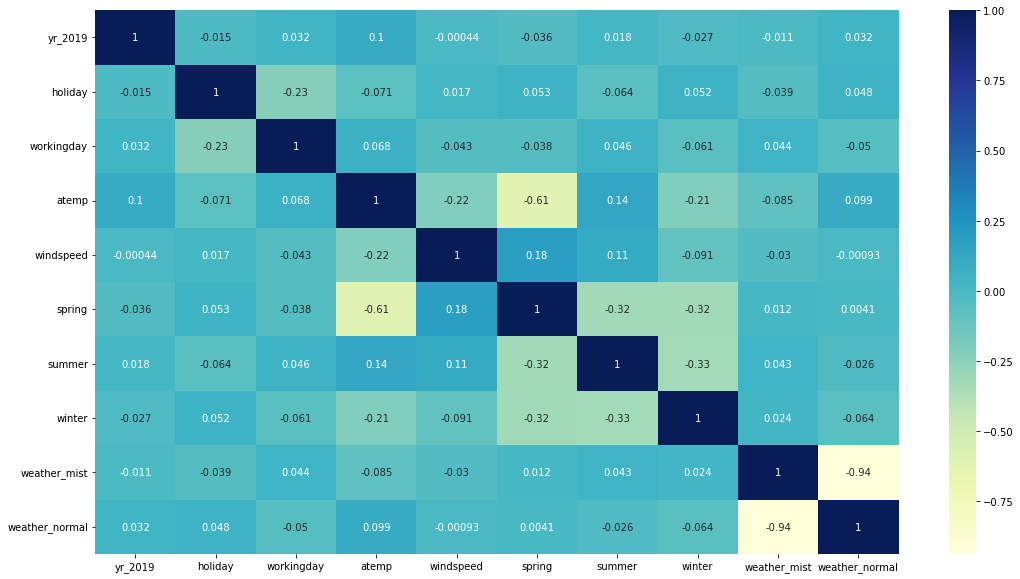

In [127]:
# correlation heatmap
plt.figure(figsize = (18, 10))
sns.heatmap(df_train.corr(), annot = True, cmap='YlGnBu')
plt.show()

In [89]:
# Get X_train, y_train, X_test, y_test
y_train = df_train.pop('cnt')
X_train = df_train
y_test = df_test.pop('cnt')
X_test = df_test

In [90]:
# Build  a model with all variables
X_train_sm = sm.add_constant(X_train)

# Create first model
lr = sm.OLS(y_train, X_train_sm)

# Fit 
lr_model = lr.fit()

# Model summary
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     227.3
Date:                Tue, 07 Jun 2022   Prob (F-statistic):          1.24e-178
Time:                        15:23:41   Log-Likelihood:                 476.12
No. Observations:                 510   AIC:                            -930.2
Df Residuals:                     499   BIC:                            -883.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0459      0.039     -1.186      0.236      -0.122       0.030
yr_2019            0.2350      0.009     27.330      0.000       0.218       0.252
holiday           -0.0723      0.028     -2.590      0.010      -0.127      -0.017
workingday         0.0180      0.009      1.912      0.056      -0.000       0.036
atemp              0.4618      0.035     13.188      0.000       0.393       0.531
windspeed         -0.1357      0.026     -5.150      0.000      -0.187      -0.084
spring            -0.1035      0.020     -5.137      0.000      -0.143      -0.064
summer             0.0237      0.014      1.729      0.084      -0.003       0.051
winter             0.0556      0.016      3.429      0.001       0.024       0.087
weather_mist       0.2001      0.026      7.626      0.000       0.149       0.252
weather_normal     0.2764      0.026     10.699      0.000       0.226       0.327
==============================================================================
Omnibus:                       60.276   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              166.220
Skew:                          -0.576   Prob(JB):                     8.05e-37
Kurtosis:                       5.549   Cond. No.                         21.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [91]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIF
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
9,weather_normal,13.93
3,atemp,11.75
8,weather_mist,7.86
4,windspeed,4.51
5,spring,3.64
2,workingday,3.18
7,winter,2.32
6,summer,2.18
0,yr_2019,2.07
1,holiday,1.09


maintain the values like: significance (p-value < 0.05) & VIF <5

- 'summer' have highest p-value > 0.05, removing this first.

In [92]:
X = X_train.drop('summer', axis = 1)

In [93]:
# build  a model with all variables
X_train_sm = sm.add_constant(X)

# create first model
lr = sm.OLS(y_train, X_train_sm)

#fit 
lr_model = lr.fit()

# model summary
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     251.2
Date:                Tue, 07 Jun 2022   Prob (F-statistic):          3.37e-179
Time:                        15:25:21   Log-Likelihood:                 474.60
No. Observations:                 510   AIC:                            -929.2
Df Residuals:                     500   BIC:                            -886.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0203      0.036     -0.567      0.571      -0.091       0.050
yr_2019            0.2354      0.009     27.342      0.000       0.219       0.252
holiday           -0.0734      0.028     -2.625      0.009      -0.128      -0.018
workingday         0.0181      0.009      1.919      0.056      -0.000       0.037
atemp              0.4342      0.031     13.897      0.000       0.373       0.496
windspeed         -0.1301      0.026     -4.967      0.000      -0.182      -0.079
spring            -0.1257      0.016     -8.059      0.000      -0.156      -0.095
winter             0.0381      0.013      3.001      0.003       0.013       0.063
weather_mist       0.2025      0.026      7.713      0.000       0.151       0.254
weather_normal     0.2783      0.026     10.763      0.000       0.228       0.329
==============================================================================
Omnibus:                       60.638   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              165.112
Skew:                          -0.583   Prob(JB):                     1.40e-36
Kurtosis:                       5.532   Cond. No.                         19.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [94]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIF
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
9,weather_normal,13.93
3,atemp,11.75
8,weather_mist,7.86
4,windspeed,4.51
5,spring,3.64
2,workingday,3.18
7,winter,2.32
6,summer,2.18
0,yr_2019,2.07
1,holiday,1.09


- 'workingday' has the next highest p-value > 0.05, removing it.

In [99]:
X = X_train.drop(['summer','workingday'], axis = 1)
# build  a model with all variables
X_train_sm = sm.add_constant(X)

# create first model
lr = sm.OLS(y_train, X_train_sm)

#fit 
lr_model = lr.fit()

# model summary
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     280.6
Date:                Tue, 07 Jun 2022   Prob (F-statistic):          1.21e-179
Time:                        15:27:29   Log-Likelihood:                 472.73
No. Observations:                 510   AIC:                            -927.5
Df Residuals:                     501   BIC:                            -889.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0061      0.035     -0.172      0.863      -0.075       0.063
yr_2019            0.2359      0.009     27.331      0.000       0.219       0.253
holiday           -0.0854      0.027     -3.128      0.002      -0.139      -0.032
atemp              0.4349      0.031     13.883      0.000       0.373       0.496
windspeed         -0.1320      0.026     -5.028      0.000      -0.184      -0.080
spring            -0.1262      0.016     -8.073      0.000      -0.157      -0.095
winter             0.0369      0.013      2.902      0.004       0.012       0.062
weather_mist       0.2016      0.026      7.661      0.000       0.150       0.253
weather_normal     0.2768      0.026     10.678      0.000       0.226       0.328
==============================================================================
Omnibus:                       65.527   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              164.914
Skew:                          -0.657   Prob(JB):                     1.55e-36
Kurtosis:                       5.456   Cond. No.                         17.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [100]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIF
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
7,weather_normal,11.46
2,atemp,10.44
6,weather_mist,6.30
3,windspeed,4.15
4,spring,2.52
0,yr_2019,2.06
5,winter,1.65
1,holiday,1.04


- Now all coefficients are <0.05 value. VIF of 'weather_normal' > 10. Hence removing it next

In [101]:
X = X_train.drop(['summer','workingday', 'weather_normal'], axis = 1)
# build  a model with all variables
X_train_sm = sm.add_constant(X)

# create first model
lr = sm.OLS(y_train, X_train_sm)

#fit 
lr_model = lr.fit()

# model summary
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     248.5
Date:                Tue, 07 Jun 2022   Prob (F-statistic):          1.29e-158
Time:                        15:28:41   Log-Likelihood:                 420.44
No. Observations:                 510   AIC:                            -824.9
Df Residuals:                     502   BIC:                            -791.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2596      0.027      9.443      0.000       0.206       0.314
yr_2019          0.2412      0.010     25.298      0.000       0.223       0.260
holiday         -0.0732      0.030     -2.424      0.016      -0.133      -0.014
atemp            0.4446      0.035     12.827      0.000       0.377       0.513
windspeed       -0.1576      0.029     -5.447      0.000      -0.214      -0.101
spring          -0.1203      0.017     -6.959      0.000      -0.154      -0.086
winter           0.0260      0.014      1.851      0.065      -0.002       0.054
weather_mist    -0.0622      0.010     -6.196      0.000      -0.082      -0.042
==============================================================================
Omnibus:                      123.120   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              428.827
Skew:                          -1.083   Prob(JB):                     7.61e-94
Kurtosis:                       6.936   Cond. No.                         13.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [102]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIF
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
3,windspeed,3.77
2,atemp,3.48
0,yr_2019,2.04
4,spring,1.62
6,weather_mist,1.47
5,winter,1.34
1,holiday,1.04


- 'winter' has p-value > 0.05. Removing the same.

In [103]:
X = X_train.drop(['summer','workingday', 'weather_normal', 'winter'], axis = 1)
# build  a model with all variables
X_train_sm = sm.add_constant(X)

# create first model
lr = sm.OLS(y_train, X_train_sm)

#fit 
lr_model = lr.fit()

# model summary
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     287.9
Date:                Tue, 07 Jun 2022   Prob (F-statistic):          4.00e-159
Time:                        15:36:59   Log-Likelihood:                 418.70
No. Observations:                 510   AIC:                            -823.4
Df Residuals:                     503   BIC:                            -793.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2911      0.022     13.456      0.000       0.249       0.334
yr_2019          0.2416      0.010     25.285      0.000       0.223       0.260
holiday         -0.0701      0.030     -2.320      0.021      -0.130      -0.011
atemp            0.4089      0.029     14.161      0.000       0.352       0.466
windspeed       -0.1647      0.029     -5.730      0.000      -0.221      -0.108
spring          -0.1391      0.014     -9.915      0.000      -0.167      -0.112
weather_mist    -0.0628      0.010     -6.247      0.000      -0.083      -0.043
==============================================================================
Omnibus:                      113.247   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              369.924
Skew:                          -1.015   Prob(JB):                     4.70e-81
Kurtosis:                       6.645   Cond. No.                         10.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [104]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIF
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
3,windspeed,3.55
2,atemp,3.48
0,yr_2019,2.02
4,spring,1.51
5,weather_mist,1.44
1,holiday,1.03


#### Residual analysis

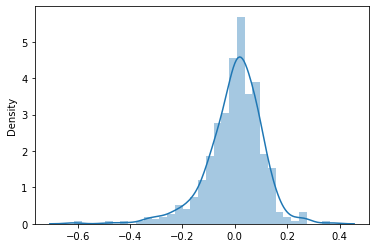

In [106]:
y_train_pred = lr_model.predict(X_train_sm)

res = y_train - y_train_pred
sns.distplot(res);

#### Prediction and evaluation on the Test Set

In [107]:
# add a constant
X_test_sm = sm.add_constant(X_test)
X_test_sm.head()

,const,yr_2019,holiday,workingday,atemp,windspeed,spring,summer,winter,weather_mist,weather_normal
184,1.0,0,1,0,0.769660,0.084219,0,0,0,1,0
535,1.0,1,0,1,0.842587,0.153728,0,1,0,0,1
299,1.0,0,0,1,0.496145,0.334206,0,0,1,1,0
221,1.0,0,0,1,0.795343,0.339570,0,0,0,0,1
152,1.0,0,0,1,0.741471,0.537414,0,1,0,0,1


In [108]:
X_test_sm = X_test_sm.drop(['summer','workingday', 'weather_normal', 'winter'], axis = 1)

# Predict
y_test_pred = lr_model.predict(X_test_sm)

# Evaluate
r2_score(y_true=y_test, y_pred=y_test_pred)

0.7700594322971313

- Evaluation r2_score is 0.7700594322971313 and model r2_score is 0.774